<a href="https://colab.research.google.com/github/hoquangthaiholy/mCNN-FAD/blob/master/mCNN_FAD_Identification_of_FAD_binding_sites_in_electron_transport_proteins_using_multiple_windows_scanning_techniques_and_convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Submission

Please submit the sequence in fasta format or just run this colab page to how mCNN-FAD works. Because we use MSA as an input format for the model. The fasta input string will be converted to PSSM via the API from our server. There, if your Uniprot ID is already available on the server, we will respond immediately. If not, we will do the conversion through the BLAST tool. This conversion usually takes about 3-5 minutes, please be patient. If you have prepared the PSSM file, please upload it to this colab page and change the filename on step 4

In [1]:
#@title 1. Prerequisite
#@markdown This step will clone the source code from Github to this colab page 
!git clone https://github.com/hoquangthaiholy/mCNN-FAD.git

Cloning into 'mCNN-FAD'...
remote: Enumerating objects: 51, done.
remote: Total 51 (delta 0), reused 0 (delta 0), pack-reused 51
Unpacking objects: 100% (51/51), done.


In [2]:
#@title 2. Submit your protein
#@markdown Please enter your protein in fasta format

uniprot_id = 'Q39243'  #@param {type: "string"}
fasta = 'MNCVSRLKCLISKARSFARLGGESTLSQPPSLASAAFSSSAVMNGLETHNTRLCIVGSGP AAHTAAIYAARAELKPLLFEGWMANDIAPGGQLTTTTDVENFPGFPEGILGVELTDKFRK QSERFGTTIFTETVTKVDFSSKPFKLFTDSKAILADAVILATGAVAKRLSFVGSGEASGG FWNRGISACAVCDGAAPIFRNKPLAVIGGGDSAMEEANFLTKYGSKVYIIHRRDAFRASK IMQQRALSNPKIDVIWNSSVVEAYGDGERDVLGGLKVKNVVTGDVSDLKVSGLFFAIGHE PATKFLDGGVELDSDGYVVTKPGTTQTSVPGVFAAGDVQDKKYRQAITAAGTGCMAALDA EHYLQEIGSQQGKSD'  #@param {type: "string"}


In [3]:
#@title 3. Convert PSSM
#@markdown This step will submit your fasta to our server and retrive PSSM profile. Depends on your protein sequence, this process might take a couple of minutes

import requests

fasta = fasta.replace(" ", "")

response = requests.post(
      'http://140.138.155.219:3000',
      data={
        'id': uniprot_id,
        'fasta': fasta
      }
    )
with open(f"{uniprot_id}.pssm", "w") as file:
    file.write(response.text)

In [4]:
#@title 4. Preparing dataset for prediction
#@markdown This step will prepare data as an input array into the model. We used (2k + 1) input size is 17

import numpy as np

NUM_FEATURE = 20
WINDOW_SIZE = 17
arr = []

# Zero-padding left
for c in range(0, (WINDOW_SIZE // 2)):
    arr.append([0]*20)

# Read PSSM file
pssm = open(f"{uniprot_id}.pssm").readlines()[3:-6]
for line in pssm:
    arr.append([float(k) for k in line.split()[2:22]])

# Zero-padding right
for c in range(0, (WINDOW_SIZE // 2)):
    arr.append([0]*20)

# Preparing dataset with sliding window
n = len(pssm)
fout = open(f"{uniprot_id}.csv","w")

x_test = []
for j in range(0, n):
  feature = arr[j:j+WINDOW_SIZE]
  _feature = []
  for line in feature:
      _feature.extend(line)
  x_test.append(_feature)
  
x_test = np.reshape( x_test, [-1,1, WINDOW_SIZE, NUM_FEATURE] )

In [5]:
#@title 5. Load mCNN-FAD model

import importlib  
module = importlib.import_module("mCNN-FAD")

model = module.mCNN()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights(f'mCNN-FAD/model/weights')

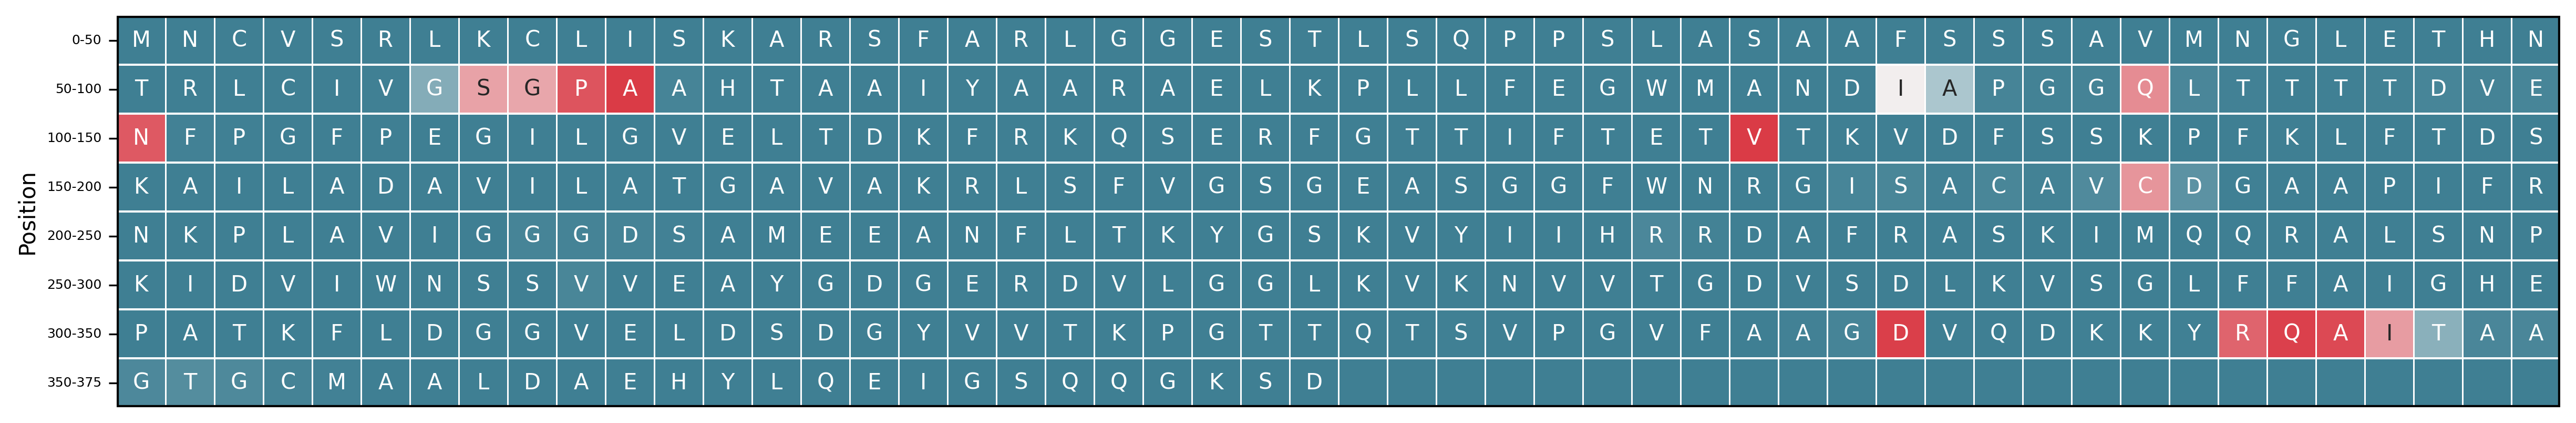

In [6]:
#@title 6. Prediction Result

import seaborn as sns
import matplotlib.pyplot as plt

pred = model.predict(x_test)

# Threshold found in training process to keep balance performance
threshold=0.004718071781098843


NUM_COLUMN = 50 #@param {type:"slider", min:20, max:50, step:10}
CMAP = "Default"  #@param ['Default', 'PuBuGn', 'OrRd', 'Rocket']

for i in range(0, NUM_COLUMN - len(pred) % NUM_COLUMN):
  fasta = fasta + ' '

ylabels = []
y_pred = np.pad(pred[:,1], (0, (NUM_COLUMN - len(pred) % NUM_COLUMN)), 'constant')
y_pred = np.reshape(y_pred,(-1,NUM_COLUMN))
anno = []

for i in range(0,len(pred), NUM_COLUMN):
  anno.append(list(fasta[i:i+NUM_COLUMN]))
  ylabels.append(f'{i}-{min(i+NUM_COLUMN,len(pred))}')

if CMAP =='Default':
  CMAP = sns.diverging_palette(220, 10, as_cmap=True)

if CMAP =='Rocket':
  CMAP = sns.cm.rocket_r

fig, ax = plt.subplots(figsize=(20, 5), dpi=300)
ax = sns.heatmap(y_pred,annot=anno, fmt="", cmap=CMAP, cbar = False, xticklabels = False,linewidths=.5, square= True)
ax.set_ylabel('Position')
ax.set_yticklabels(ylabels, rotation=0, fontsize=6)
ax.axhline(y=0, color='k',linewidth=2)
ax.axhline(y=len(pred) // NUM_COLUMN + 1, color='k',linewidth=2)
ax.axvline(x=0, color='k',linewidth=2)
ax.axvline(x=NUM_COLUMN, color='k',linewidth=2)
fig.savefig(f"{uniprot_id}.svg",format="svg")

In [7]:
#@title 7. Ranking filters
from tensorflow.keras import Model, layers
from sklearn.ensemble import ExtraTreesClassifier

dropout_out = model.layers[21].output
model_dropout = Model(inputs=model.input_layer, outputs=dropout_out)
feature_dropout = model_dropout.predict(x_test)

# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

bin_pred = (pred[:, 1] >= threshold).astype(int)

forest.fit(feature_dropout,bin_pred)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Top 3 filter ranking:")

filter_rankings = []
for f in range(0,3):
  filter_rankings.append(indices[f])
  print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Top 3 filter ranking:
1. feature 2470 (0.009109)
2. feature 973 (0.009049)
3. feature 623 (0.005373)


> Top 3 filter 



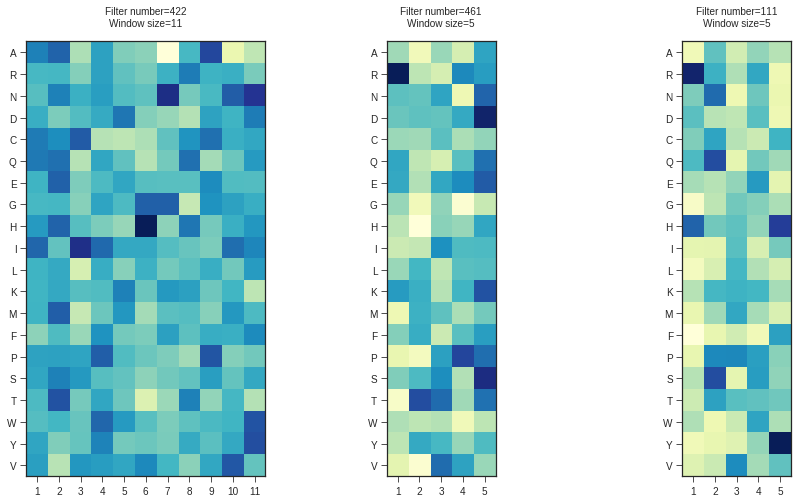

findfont: Font family ['Q39243_logo_19.svg'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Q39243_logo_19.svg'] not found. Falling back to DejaVu Sans.



> SEQUENCE LOGO



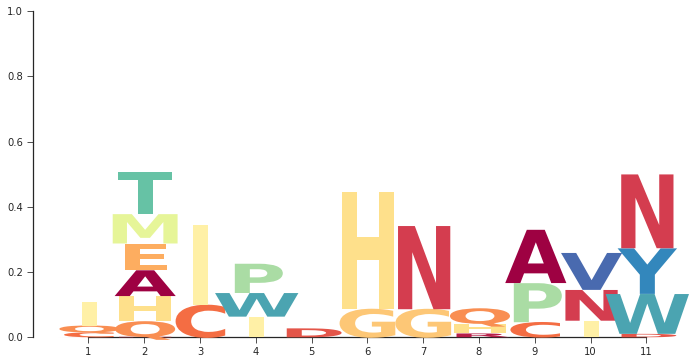

Filter number=422
Window size=11



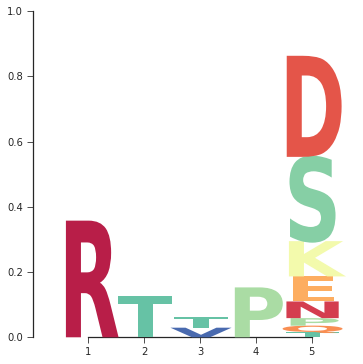

Filter number=461
Window size=5



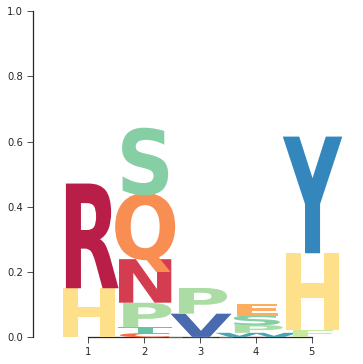

Filter number=111
Window size=5



In [11]:
#@title 8. Sequence Logo Visualization
import seaborn
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
from matplotlib import transforms
import matplotlib.patheffects
from matplotlib.font_manager import FontProperties
import matplotlib as mpl

import numpy as np

WINDOW_SIZES = [3,5,7,9,11,15,17]
NUM_FILTER = 512

aa = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
cmap = matplotlib.cm.get_cmap('Spectral')

COLOR_SCHEME = {}
for i in range(20):
  COLOR_SCHEME[aa[i]] = cmap(i/20)

class Scale(matplotlib.patheffects.RendererBase):
    def __init__(self, sx, sy=None):
        self._sx = sx
        self._sy = sy

    def draw_path(self, renderer, gc, tpath, affine, rgbFace):
        affine = affine.identity().scale(self._sx, self._sy)+affine
        renderer.draw_path(gc, tpath, affine, rgbFace)

def draw_logo(all_scores, fontfamily='DejaVu Sans', size=80, filename='logo'):
    if fontfamily == 'xkcd':
        plt.xkcd()
    else:
        mpl.rcParams['font.family'] = fontfamily

    fig, ax = plt.subplots(figsize=(len(all_scores),6))
    ax.spines['left'].set_visible(False)

    font = FontProperties()
    font.set_size(size)
    font.set_weight('bold')
    
    #font.set_family(fontfamily)

    ax.set_xticks(range(1,len(all_scores)+1))    
    # ax.set_yticks(range(0,math.ceil(maxval)*10))
    ax.set_xticklabels(range(1,len(all_scores)+1), rotation=0)
    # ax.set_yticklabels(np.arange(0,math.ceil(maxval)*10,1))
    seaborn.despine(ax=ax, trim=True)
    
    trans_offset = transforms.offset_copy(ax.transData, 
                                          fig=fig, 
                                          x=1, 
                                          y=0, 
                                          units='dots')
   
    for index, scores in enumerate(all_scores):
        yshift = 0
        for base, score in scores:
            txt = ax.text(index+1, 
                          0, 
                          base, 
                          transform=trans_offset,
                          fontsize=80, 
                          color=COLOR_SCHEME[base],
                          ha='center',
                          fontproperties=font,
                         )
            txt.set_path_effects([Scale(1.0, score*2)])
            fig.canvas.draw()
            window_ext = txt.get_window_extent(txt._renderer)
            yshift = window_ext.height*score*1.5
            trans_offset = transforms.offset_copy(txt._transform, 
                                                  fig=fig,
                                                  y=yshift,
                                                  units='dots')
        trans_offset = transforms.offset_copy(ax.transData, 
                                              fig=fig, 
                                              x=1, 
                                              y=0, 
                                              units='dots')
    plt.show()
    fig.savefig(filename,format="svg")

aa = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']

con2d_weights = []
for layer in model.layers:
	# check for convolutional layer
  if 'conv' not in layer.name:
    continue
	# get filter weights
  filters, biases = layer.get_weights()
  con2d_weights.append(filters)

fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(15,8),
    subplot_kw={'xticks': [], 'yticks': []}
)

print('> Top 3 filter \n')
for i in range(0,3):
  filter_ranking = filter_rankings[i]
  window_id = filter_ranking // NUM_FILTER
  filter_id = filter_ranking % NUM_FILTER
  filter_map = con2d_weights[window_id][0,:,:,filter_id]
  axs[i].imshow(filter_map.T,plt.cm.YlGnBu,interpolation="nearest")
  axs[i].set_yticklabels(aa)
  axs[i].xaxis.tick_bottom()
  axs[i].xaxis.set_label_position('top')
  axs[i].set_xlabel(f'Filter number={filter_id}\nWindow size={WINDOW_SIZES[window_id]}\n')
  axs[i].set_yticks(np.arange(len(aa)))
  axs[i].set_xticks(np.arange(WINDOW_SIZES[window_id]))
  axs[i].set_xticklabels(range(1,WINDOW_SIZES[window_id]+1))

plt.show()
fig.savefig(f"{uniprot_id}_filters.svg",format="svg")

print('\n> SEQUENCE LOGO\n')
for i in range(0,3):
  filter_ranking = filter_rankings[i]
  window_id = filter_ranking // NUM_FILTER
  filter_id = filter_ranking % NUM_FILTER
  filter_map = con2d_weights[window_id][0,:,:,filter_id]

  clip_level = 0.1
  filter_maps = np.clip(filter_map,clip_level,np.max(filter_map))
  filter_maps = (filter_maps-np.min(filter_maps))/(np.max(filter_maps)-np.min(filter_maps))
  cmap = matplotlib.cm.get_cmap('Spectral')

  weblogo = []
  maxval = 0
  for filter in filter_maps:
    pos = []
    _maxval = 0
    for i in range(20):
      _maxval = _maxval + filter[i]
      pos.append((aa[i],filter[i]))
    pos.sort(key=lambda x:x[1])
    weblogo.append(pos)
    if (_maxval > maxval):
      maxval = _maxval
  
  draw_logo(weblogo,f"{uniprot_id}_logo_{i}.svg")
  print(f'Filter number={filter_id}\nWindow size={WINDOW_SIZES[window_id]}\n')